In [1120]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)


sys.path.append('../')
import xai
reload(xai)
import xai

In [1121]:
csv_path = 'data/adult.data'
categorical_cols = ["gender", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "native-country", "loan"]
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]

In [1156]:
df = pd.read_csv(csv_path, names=csv_columns)
del df["fnlwgt"]
del df["native-country"]
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,loan
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K


In [1165]:
target = "loan"
protected = ["gender", "ethnicity", "age"]

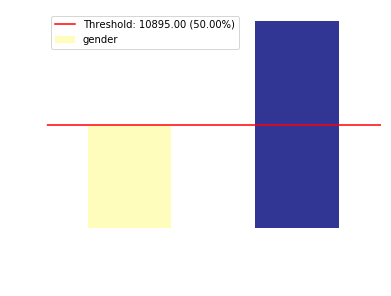

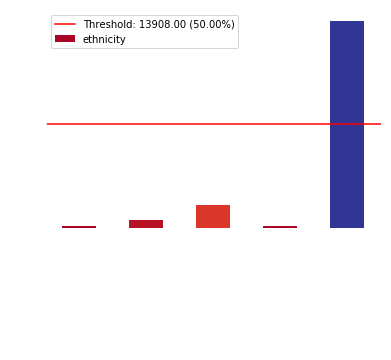

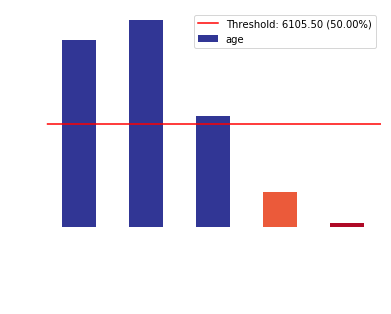

In [1166]:
ims = xai.show_imbalances(df, protected)

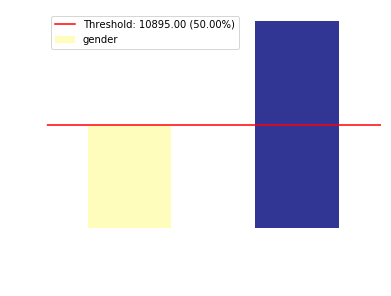

In [1167]:
im = xai.show_imbalance(df, "gender")

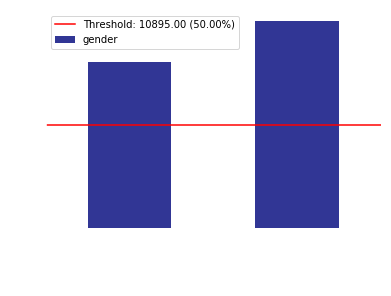

In [1168]:
bal_df = xai.balance(df, "gender", upsample=0.8)

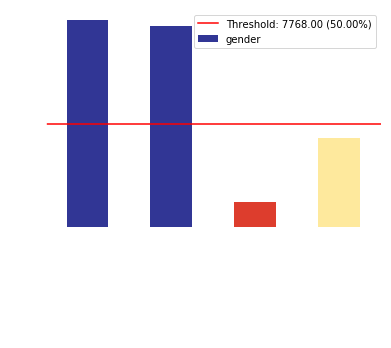

In [1169]:
im = xai.show_imbalance(bal_df, "gender", cross=["loan"])

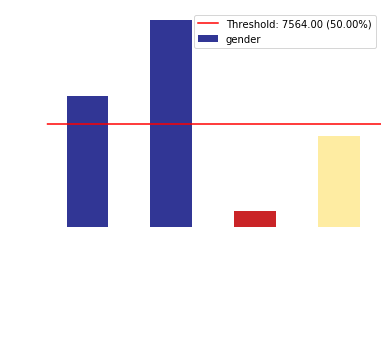

(32561, 13)

In [1170]:
bal_df = xai.balance(df, "gender", cross=["loan"], upsample=0, downsample=1)
bal_df.shape

In [1173]:

proc_df = xai.normalize_numeric(bal_df)
proc_df = xai.convert_categories(proc_df)
x = proc_df.drop("loan", axis=1)
y = proc_df["loan"]

x_train, y_train, x_test, y_test = xai.balanced_train_test_split(
            x, y, cross=["gender"], 
            categorical_cols=categorical_cols, min_per_class=300,
            fallback_type="half")

print(x_test.shape)

(1200, 12)


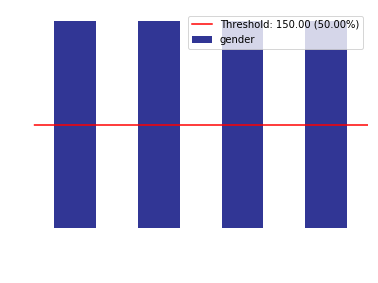

In [1174]:
df_test = x_test.copy()
df_test["loan"] = y_test

_= xai.show_imbalance(df_test, "gender", cross=["loan"], categorical_cols=categorical_cols)

In [1175]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc

from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding

def build_model(X):
    input_els = []
    encoded_els = []
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(X[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model


def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs, threshold=0.5):
    """Convert probabilities into classes"""
    return list((probs >= threshold).astype(int).T[0])


In [1176]:
model = build_model(proc_df.drop("loan", axis=1))

model.fit(f_in(x_train), y_train, epochs=50, batch_size=512)

Epoch 1/50
31361/31361 [==============================] - 3s 97us/step - loss: 0.5523 - acc: 0.7563
Epoch 2/50
31361/31361 [==============================] - 0s 5us/step - loss: 0.3962 - acc: 0.8230
Epoch 3/50
31361/31361 [==============================] - 0s 5us/step - loss: 0.3419 - acc: 0.8429
Epoch 4/50
31361/31361 [==============================] - 0s 5us/step - loss: 0.3228 - acc: 0.8500
Epoch 5/50
31361/31361 [==============================] - 0s 5us/step - loss: 0.3183 - acc: 0.8520
Epoch 6/50
31361/31361 [==============================] - 0s 5us/step - loss: 0.3137 - acc: 0.8552
Epoch 7/50
31361/31361 [==============================] - 0s 5us/step - loss: 0.3110 - acc: 0.8560
Epoch 8/50
31361/31361 [==============================] - 0s 6us/step - loss: 0.3101 - acc: 0.8574
Epoch 9/50
31361/31361 [==============================] - 0s 6us/step - loss: 0.3087 - acc: 0.8569
Epoch 10/50
31361/31361 [==============================] - 0s 6us/step - loss: 0.3077 - acc: 0.8574
Epoch 11

In [1177]:
score = model.evaluate(f_in(x_test), y_test, verbose=1)
print("Error %.4f: " % score[0])
print("Accuracy %.4f: " % (score[1]*100))

1200/1200 [==============================] - 1s 1ms/step
Error 0.5420: 
Accuracy 74.2500: 


In [1178]:
probabilities = model.predict(f_in(x_test))
pred = f_out(probabilities)

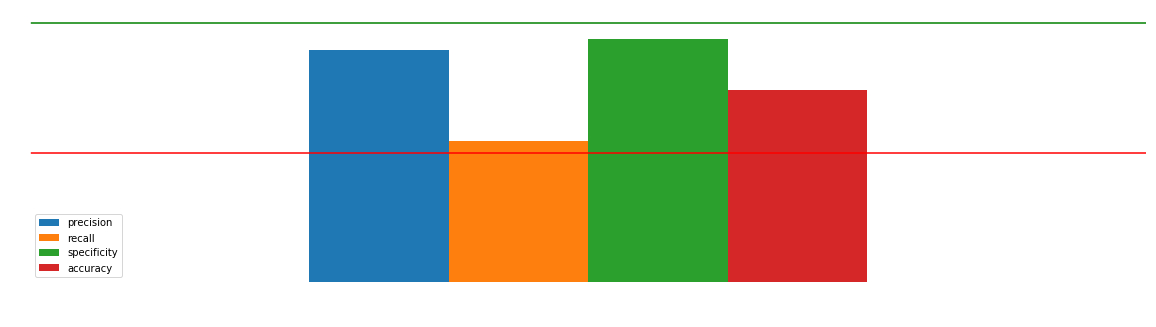

In [1184]:
_= xai.metrics_imbalance(
        x_test, 
        y_test, 
        probabilities)

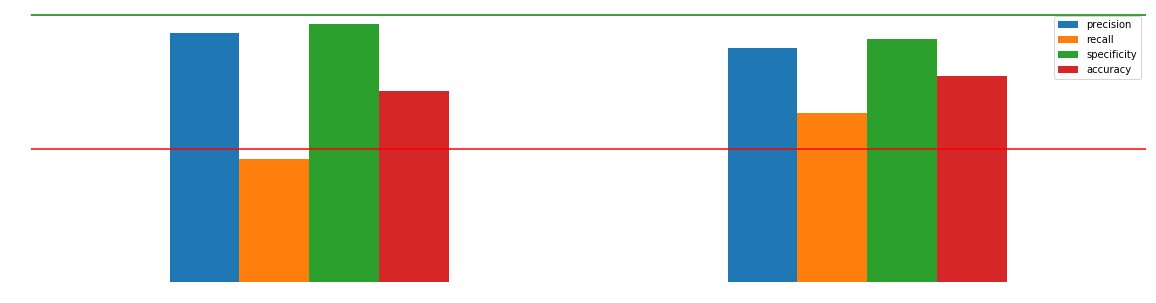

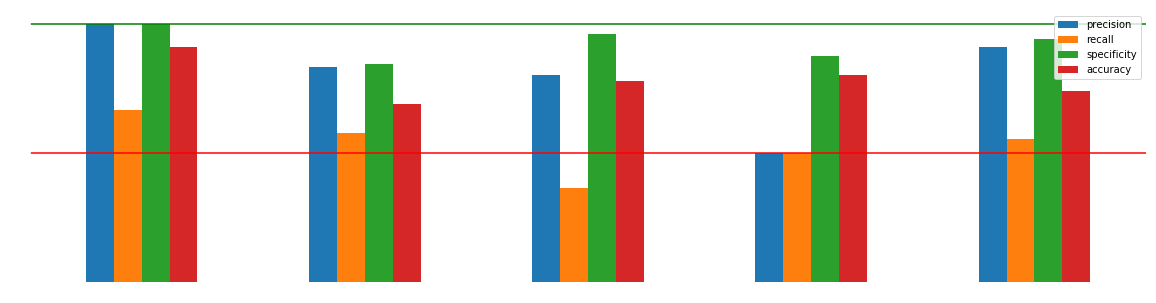

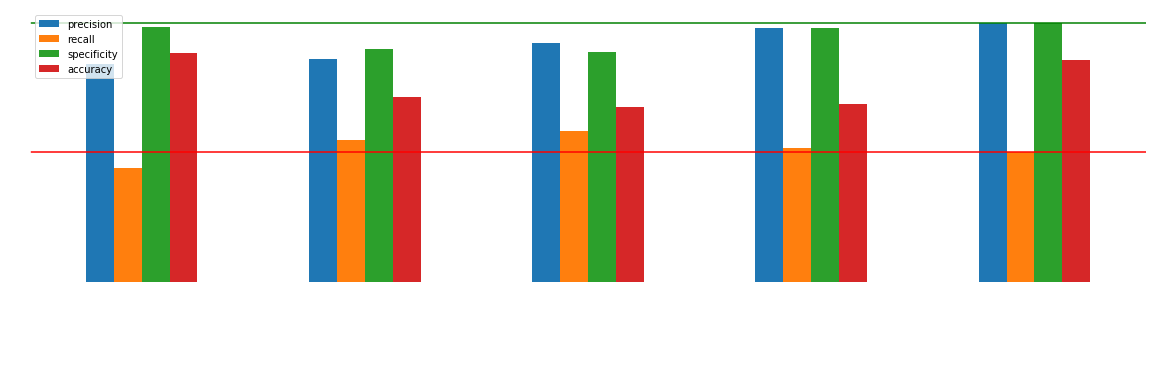

In [1185]:
_= xai.metrics_imbalances(
        x_test, 
        y_test, 
        probabilities,
        columns=protected,
        categorical_cols=categorical_cols)

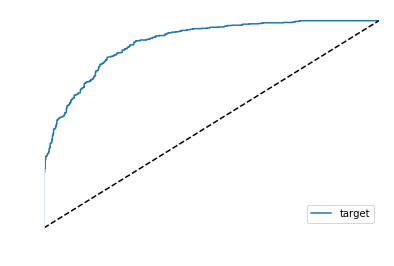

In [1182]:
_= xai.roc_imbalance(
    x_test, 
    y_test, 
    probabilities)

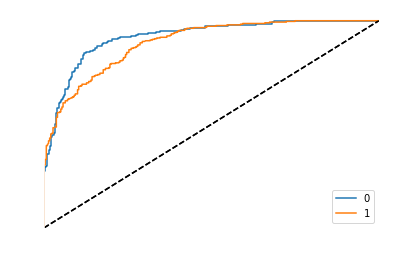

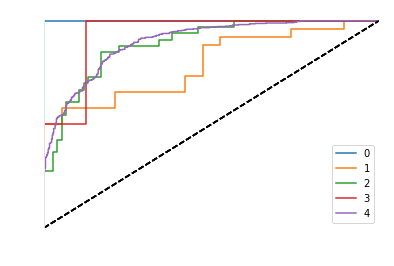

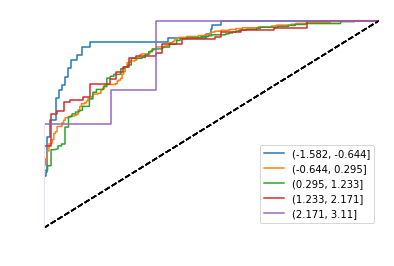

In [1183]:
_= xai.roc_imbalances(
    x_test, 
    y_test, 
    probabilities, 
    columns=protected,
    categorical_cols=categorical_cols)

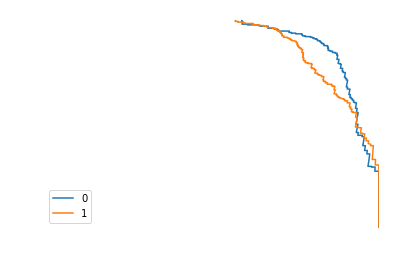

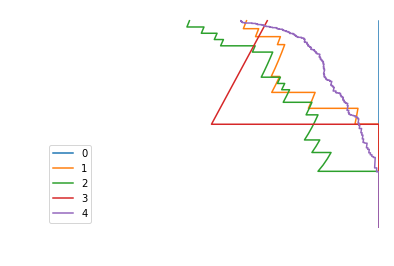

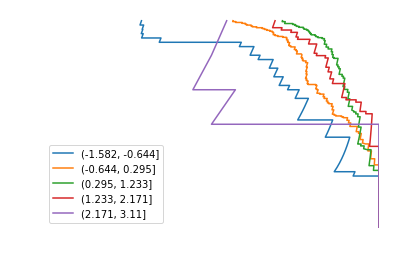

In [1181]:
_= xai.pr_imbalances(
    x_test, 
    y_test, 
    probabilities, 
    columns=protected,
    categorical_cols=categorical_cols)

In [ ]:
def prediction_imbalance(
        y_test, 
        probs, 
        threshold=0.5, 
        manual_review=None,
        display_breakdown=False,
        bins=10):
    


/home/alejandro/.local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


probs              387.027734
preds              362.000000
target             600.000000
true-positives     328.000000
true-negatives     566.000000
false-positives     34.000000
false-negatives    272.000000
manual-review        0.000000
correct            894.000000
incorrect          306.000000
dtype: float64

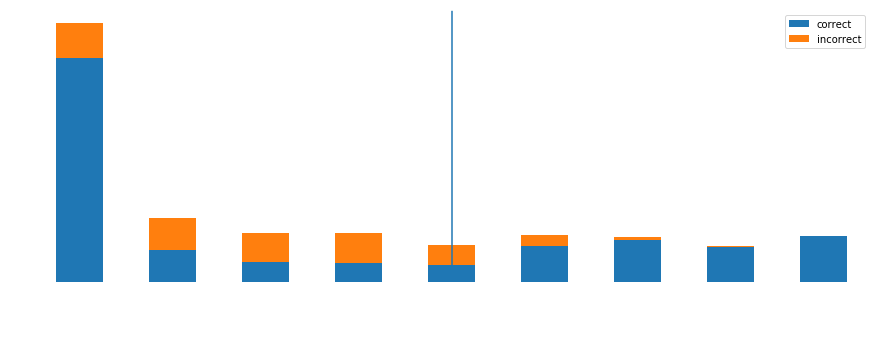

In [1155]:
d = xai.smile_imbalance(
    y_test, 
    probabilities)

d.sum()

/home/alejandro/.local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


probs              618.644622
preds              658.000000
target             600.000000
true-positives     525.000000
true-negatives     467.000000
false-positives    133.000000
false-negatives     75.000000
manual-review        0.000000
correct            992.000000
incorrect          208.000000
dtype: float64

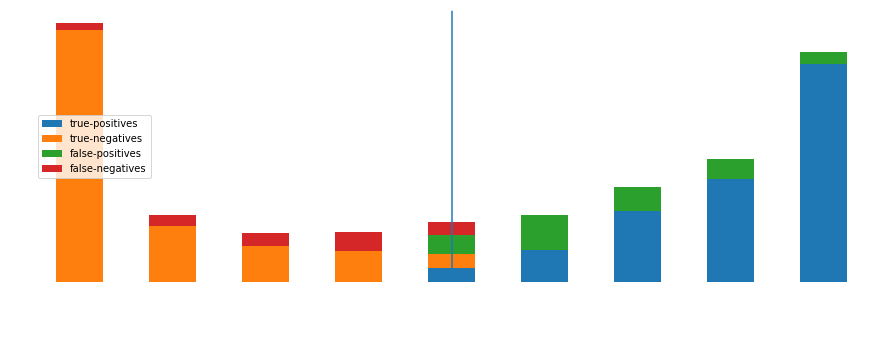

In [1143]:
d = smile_imbalance(
    y_test, 
    probabilities,
    display_breakdown=True)
d.sum()

/home/alejandro/.local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


probs              618.644622
preds              458.000000
target             600.000000
true-positives     409.000000
true-negatives     551.000000
false-positives     49.000000
false-negatives    191.000000
manual-review      261.000000
correct            844.000000
incorrect           95.000000
dtype: float64

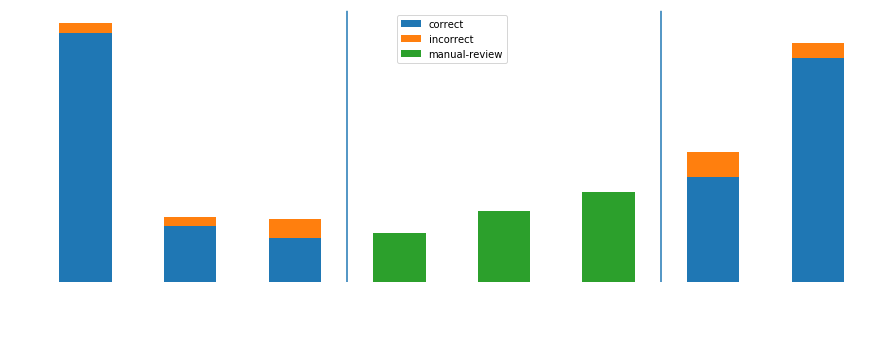

In [1144]:
d = smile_imbalance(
    y_test, 
    probabilities,
    bins=9,
    threshold=0.75,
    manual_review=0.375,
    display_breakdown=False)
d.sum()

probs            577.384597
preds            359.000000
target           600.000000
tps              339.000000
tns              580.000000
fps               20.000000
fns              261.000000
manual-review    297.000000
correct          815.000000
incorrect         88.000000
dtype: float64

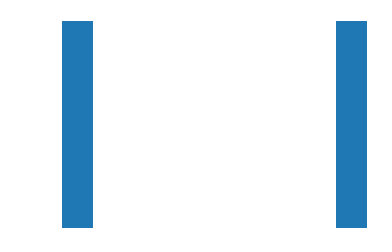

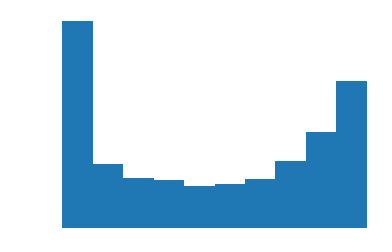

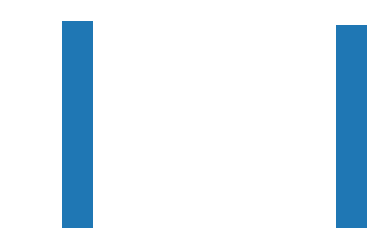

In [1008]:
d["target"].plot.hist(bins=10)
plt.show()
d["probs"].plot.hist(bins=10)
plt.show()
d["preds"].plot.hist(bins=10)